In [1]:
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

#### Model and variable

In [2]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param',1)
    data_generator = pm.Poisson('data_generator', parameter)

#### Deterministic

If you know parameter of a variable, you can determined this variable

In [3]:
with model:
    data_plus_one = pm.Deterministic('data_plus_one',data_generator + 1)

**`variable.tag.test_value`: accessing variable out of the model(not create variables)**

In [4]:
parameter.tag.test_value,data_generator.tag.test_value,data_plus_one.tag.test_value

(array(0.69314718), array(0, dtype=int64), array(1, dtype=int64))

#### Vectorization

In [5]:
n_data_points = 5

idx = np.arange(n_data_points)

with pm.Model() as model:
    # 2-vector
    lambdas = pm.Exponential('lambdas', 1.0, shape = 2)
    
    # scaler
    tau = pm.DiscreteUniform('tau', 0,10)
    
    # 5-vector, for all values of idx, compare with tau
    # base on result, assign lambda_ with lambdas[0] or lambdas[1]
    lambda_ = pm.math.switch(idx < tau, lambdas[0], lambdas[1])

In [6]:
lambdas.tag.test_value,tau.tag.test_value

(array([0.69314718, 0.69314718]), array(5, dtype=int64))

In [7]:
lambda_.tag.test_value

array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718])

#### Theano

Samplle a bernoulli distribnution using Categorical

In [8]:
import theano.tensor as tt

with pm.Model() as model:
    p1 = pm.Uniform('p1', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical('assignment', p)

In [9]:
p1.tag.test_value, p2.tag.test_value,p.tag.test_value, assignment.tag.test_value

(array(0.5), array(0.5), array([0.5, 0.5]), array(0, dtype=int64))

Sample a categorical variable using Dirichlet distribution and categorical

In [10]:
with pm.Model() as model:
    ps = pm.Dirichlet('ps',a = [0.1, 0.5, 0.4])
    assignment = pm.Categorical('assignment', ps)
    
    trace = pm.sample(1000, return_inferencedata = True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [ps]
>CategoricalGibbsMetropolis: [assignment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.


#### Including observations 

In [19]:
data = np.array([10, 5])

with pm.Model() as model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
    
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


### Example

#### Create a transition dataset

In [20]:
plt.style.use('bmh')

In [21]:
from scipy import stats


def make_artificial_dataset():
    # define transition point
    tau = np.random.randint(0,80)

    # parameter determin the possion parameter
    alpha = 1 / 20.

    # parameter determinal possion
    lambda_1, lambda_2 = np.random.exponential(1/ alpha, size = 2)

    # poisson
    return np.r_[stats.poisson.rvs(lambda_1, size = tau), 
                 stats.poisson.rvs(lambda_2, size = 80 - tau)], tau

def plot_data(data, tau):
    plt.bar(np.arange(80), data, color = '#348ABD')
    plt.bar(tau-1, data[tau-1], color = 'r')

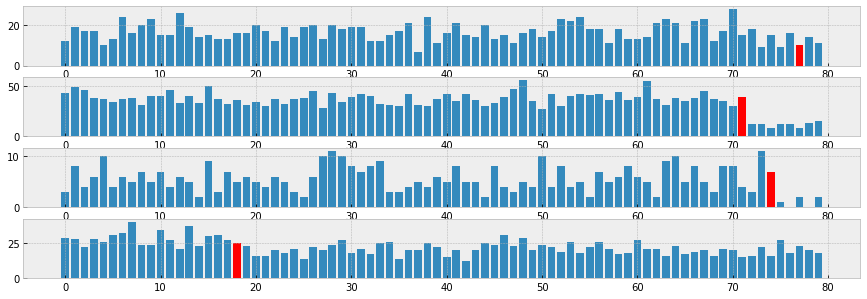

In [22]:
figsize(15,5,)
plt.title("Artifical dataset")

for i in range(4):
    plt.subplot(4,1,i+1)
    plot_data(*make_artificial_dataset())
plt.show()

#### Resamble the data creation process using pymc

In [64]:
data, tau_true = make_artificial_dataset()

In [66]:
idx = np.arange(len(data))

In [98]:
alpha = 1 / np.mean(data)

with pm.Model() as model:
    
    # lambdas control poisson distributions
    lambdas = pm.Exponential('lambdas', alpha, shape = 2)
    
    
    # tau define transition points
    tau = pm.DiscreteUniform("tau", 1, len(data))
    
    # assign poisson parameter based on tau [vectorized]
    lambda_assignment = pm.math.switch(idx <= tau, lambdas[0], lambdas[1])
    
    # vectorized poisson
    obs = pm.Poisson('obs', lambda_assignment, observed = data)

In [100]:
with model:
    trace = pm.sample(10000,return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambdas]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.
C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


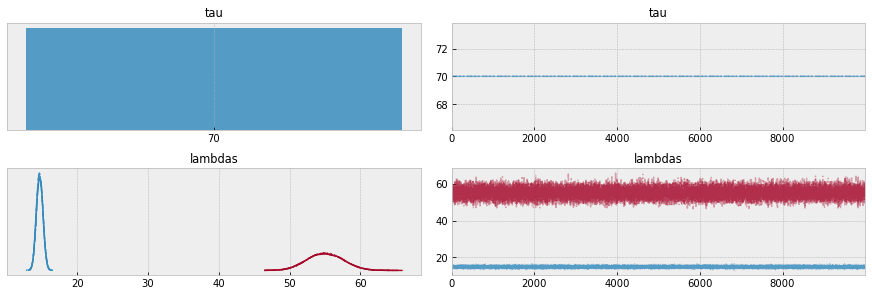

In [101]:
az.plot_trace(trace)
plt.show()

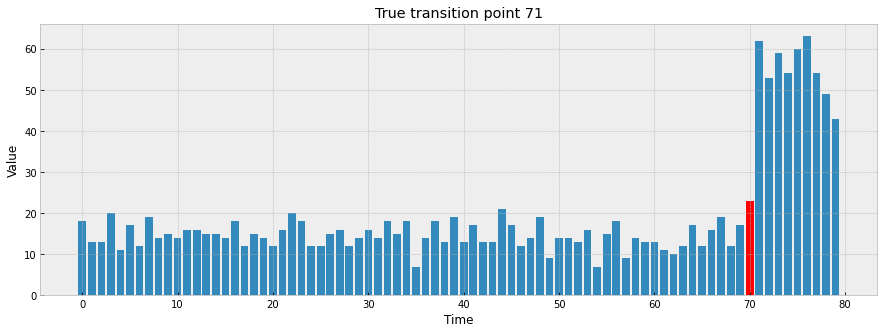

In [102]:
plot_data(data, tau_true)
plt.title(f'True transition point {tau_true}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Go AB testing

**Only a A sample without B : Estimate a rate(probability)**

In [103]:
true_p = 0.3

data = stats.bernoulli(true_p).rvs(100)

print('probability from data: {}'.format(data.mean()))

with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)
    obs = pm.Bernoulli('obs',p, observed = data)
    trace = pm.sample(1000,return_inferencedata=True)

probability from data: 0.33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


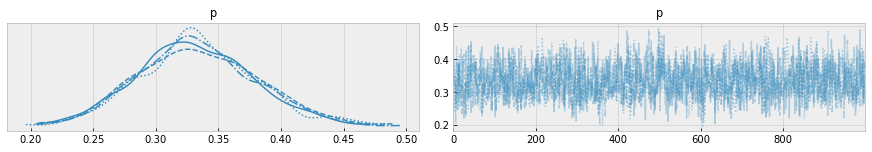

In [104]:
az.plot_trace(trace)
plt.show()

**A and B together**

#### Simulate a dataset

**You know the creation process of the dataset**

In [105]:
pa_true, pb_true = np.random.random(size = 2)
print('True probabilities: ')
print('A samples: {}'.format(pa_true))
print('B samples: {}'.format(pb_true))

N_A = 1500
N_B = 750

observation_A = stats.bernoulli.rvs(pa_true, size = N_A)
observation_B = stats.bernoulli.rvs(pb_true, size = N_B)

print('Data A: {}'.format(np.mean(observation_A)))
print('Data B: {}'.format(np.mean(observation_B)))

True probabilities: 
A samples: 0.21434497084821347
B samples: 0.8332524201422814
Data A: 0.21466666666666667
Data B: 0.792


**Observed A, B together with a delta, then report the probability distribution of delta**

In [106]:
with pm.Model() as model:
    p_A = pm.Uniform('p_A',0, 1)
    p_B = pm.Uniform('p_B',0, 1)
    
    delta = pm.Deterministic('delta', p_A - p_B)
    
    obs_A = pm.Bernoulli('observation_A',p_A, observed = observation_A)
    obs_B = pm.Bernoulli('observation_B',p_B, observed = observation_B)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, step = step, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


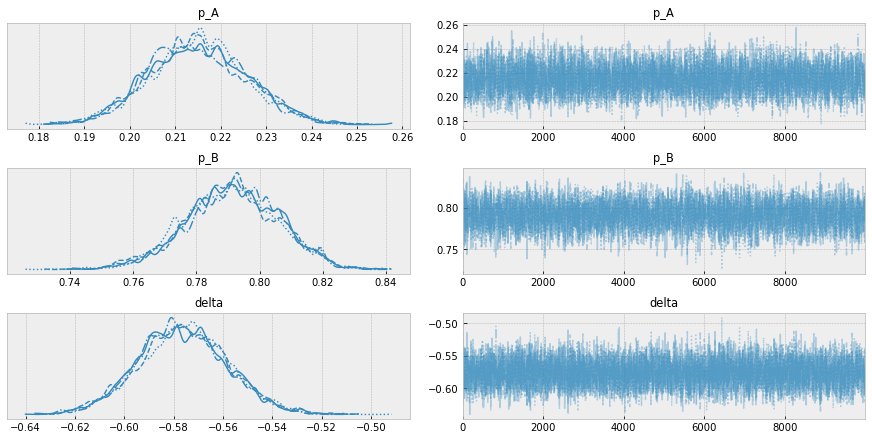

In [107]:
az.plot_trace(trace)
plt.show()

In [108]:
p_conf = (trace.posterior['delta'].values[:,2000:].reshape(-1) < 0).mean()

print('Belief of A is smaller than B is {}'.format(p_conf))

Belief of A is smaller than B is 1.0


## Cheaters

In [109]:
N = 100

X = 35

In [110]:
import theano.tensor as tt

with pm.Model() as model:
    
    # define cheat ratio here[0 - no cheat, 1 - cheat]
    p = pm.Uniform('p', 0, 1)
    
    # define a true answer
    true_answers = pm.Bernoulli('truth_answers', p, shape = N, testval=np.random.binomial(1, 0.5, N))
    
    # flip coins
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape = N, testval=np.random.binomial(1, 0.5, N))
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape = N, testval=np.random.binomial(1, 0.5, N))
    
    # [first head and cheater get a 1 else 0]  [first tail && second head get a 1 else 0]
    val = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips
    
    observed_proportion = pm.Deterministic("Observed_proportion", tt.sum(val) / float(N))
    
    observations = pm.Binomial('obs', N, observed_proportion, observed = X)
    
    step = pm.Metropolis(vars = [p])

    trace = pm.sample(40000, return_inferencedata=True, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p]
>BinaryGibbsMetropolis: [truth_answers, first_flips, second_flips]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 518 seconds.
The number of effective samples is smaller than 10% for some parameters.


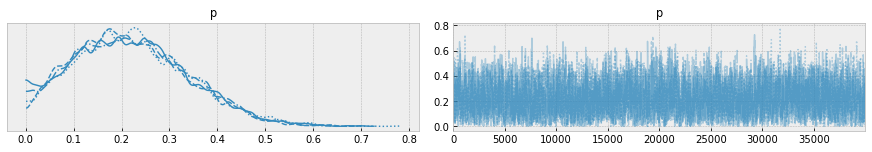

In [112]:
az.plot_trace(trace.posterior['p'])
plt.show()